In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import itertools as iter
import math
from sklearn.preprocessing import MinMaxScaler
import moo_functions as moo
from moo_functions import evaluate_solution_metrics
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

import random
from math import inf
from tqdm import tqdm

# Part 1: Problem & Topic Introduction

**Too many choices**  
Making a decision about anything, big or small, whether or business or in life, always involves weighing objectives. Even a choice as seemingly simple as where to sit on the couch requires careful consideration of things like a spot's proximity to you, to others, to the TV, to the bowl of chips, etc., with your brain in the background finding the best solution hundreds of times per day.  
These problems, in which the best path forward isn't one lone calcuation but an assortment of competing ones, are called **multi-objective**, and math & data science give us tools to investigate them.  

**Pack your bags!**  
We'll be demonstrating these tools using an example use case of packing the best suitcase for a trip.  
### Example Clothes & Objectives

Let's say you have 20 of your favorite clothing items, and *technically* they can just barely fit in your luggage, but the fit is tight, making repacking and buying souvenirs annoying, so you're looking to optimize.  
Your primary objectives are:
1. **Volume**: First and foremost - obviously we favor smaller/more compact items.
2. **# of Outfits Available**: If an outfit is a top & bottom combo that abides by your rules (e.g. can't wear pink stripes with blue polka dots), you want to have as many possible outfits on the trip.
3. **Liking**: Everyone has a favorite top or maybe lucky pair of pants, as well as that sweater with the stain or the shorts that fit better back in college. You might excuse some extra volume from the lucky pair, or prefer not to pack the stained sweater even if it "goes with everything".

So you gather all 20 items and write down their volumes (from 1-3), liking rating (from 1-5), and info for outfit matching them like color or pattern:

In [2]:
tops_df = pd.read_csv("tops", index_col=False)
bottoms_df = pd.read_csv("bottoms", index_col=False)

tops_dict = tops_df.to_dict(orient='records')
bottoms_dict = bottoms_df.to_dict(orient='records')

num_tops = len(tops_dict)
num_bottoms = len(bottoms_dict)
all_clothes_list = tops_dict + bottoms_dict

objectives = ["outfits_lost", "volume", "liking_diff"]

display(tops_df)
display(bottoms_df)

,Name,volume,Liking Rating,Color,Patterned?,Length
0,Linen Tee,3,5,White,Yes,3
1,Striped White Tee,2,3,White,Yes,3
2,Blue Floral Tank,1,2,Blue,Yes,3
3,Blue Button-up,2,3,Blue,Yes,3
4,Black Workout Top,1,3,Black,No,2
5,Green Workout Top,1,3,Green,No,3
6,Beige White Tank,2,4,White,No,2
7,Beaded Black Tank,2,5,Black,Yes,2
8,Orange Button Up,3,3,Orange,No,3
9,Long Sleeve Button-up,3,4,White,Yes,3


,Name,volume,Liking Rating,Color,Patterned?,Highest Rise
0,Striped Linen Pants,3,3,White,Yes,2
1,Blue Striped Linen Pants,3,5,Blue,Yes,1
2,Jean Shorts,2,4,Blue,No,3
3,Long Blue Skirt,1,5,Blue,Yes,1
4,Long White Skirt,2,5,White,No,2
5,Black Skirt,2,4,Black,No,2
6,Green Shorts,2,3,Green,No,2
7,Long Red Pants,4,4,Red,No,1
8,Biker Shorts,1,2,Black,No,1


This is our "full" suitcase, and for the objectives we're prioritizing we have:

In [3]:
total_possible_outfits = moo.total_outfits(tops_dict, bottoms_dict)
total_volume = sum([x for x in [d["volume"] for d in tops_dict if "volume" in d]] + \
                   [x for x in [d["volume"] for d in bottoms_dict if "volume" in d]])
total_liking = sum([x for x in [d["Liking Rating"] for d in tops_dict if "Liking Rating" in d]] + \
                   [x for x in [d["Liking Rating"] for d in bottoms_dict if "Liking Rating" in d]])
full_liking = evaluate_solution_metrics(np.ones(20), num_tops, num_bottoms, all_clothes_list)[2]

print("1." , total_volume , "total volume")
print("2." , total_possible_outfits , "possible outfits")
print("3." , total_liking , "liking rating sum")

1. 42 total volume
2. 61 possible outfits
3. 73 liking rating sum


This suitcase has the max/best # of outfits, the max/worst volume, and the max liking rating sum.  
An empty suitcase would have the worst # of outfits (0), the best volume (0), and a liking rating sum of 0 as well.  
What were hoping is that somewhere in between the full and the empty lies a "best" suitcase, and to start, we need to **define an *ideal* suitcase**. A *best* suitcase is our favorite one that is actually possible, an *ideal* is the best hypothetical solution that isn't possible due to the trade-offs, e.g. in this case, a suitcase with all 61 outfits but 0 volume isn't possible (unless you are Mary Poppins), but the methods and algorithms we employ later still need the ideal solution for mathematical computation (e.g. solution A is better than B is the euclidean distance to the ideal is smaller). The algorithms also generally assume a consistant directionality, namely the lower the metric -> the better.  
  
How we would have to define our metrics to account for this:  
1. For volume: we are all set - our current, "worst" volume is the max and a volume of 0 would be "perfect".
2. For outfits: instead of raw # of outfits possible, we can take "outfits lost" from each solution (61 minus given # of outfits) - the full suitcase having a score of 0 (perfect) and an empty one having a score of 61.
3. For liking: we could do the same thing as with outfits, but for some added complexity, what if we penalized less liked items instead of just summing them all up. We can calculate a suitcase liking score by having each item's liking rating improve the suitcase liking score if the rating is above average, and worsen it if it's below average - thus a full suitcase isn't perfect because it includes some "bad" items, but an empty one also isn't since it excludes some "good" ones. For reference, the suitcase with only above average items would have a liking score of -75.

So now, **the ideal suitcase** has the scores **(0, 0, -75)**, and the full suitcase has the scores:

In [4]:
evaluate_solution_metrics(np.ones(20), num_tops, num_bottoms, all_clothes_list)

(0, 42, -65)

Lots of improvement to be made!

### Visualizing the solution space

Now, with these three objectives in mind, how do we go about finding the best way to pack?  
We can start by visualizing the feature space we're dealing with - i.e. every possible suitcase

**3D Representation:**

In [5]:
all_objs = pd.DataFrame(np.load('all_solns.npy'), columns=objectives)
vis_subset = all_objs.sample(frac=0.05, random_state=42) # subset for smooth visualization

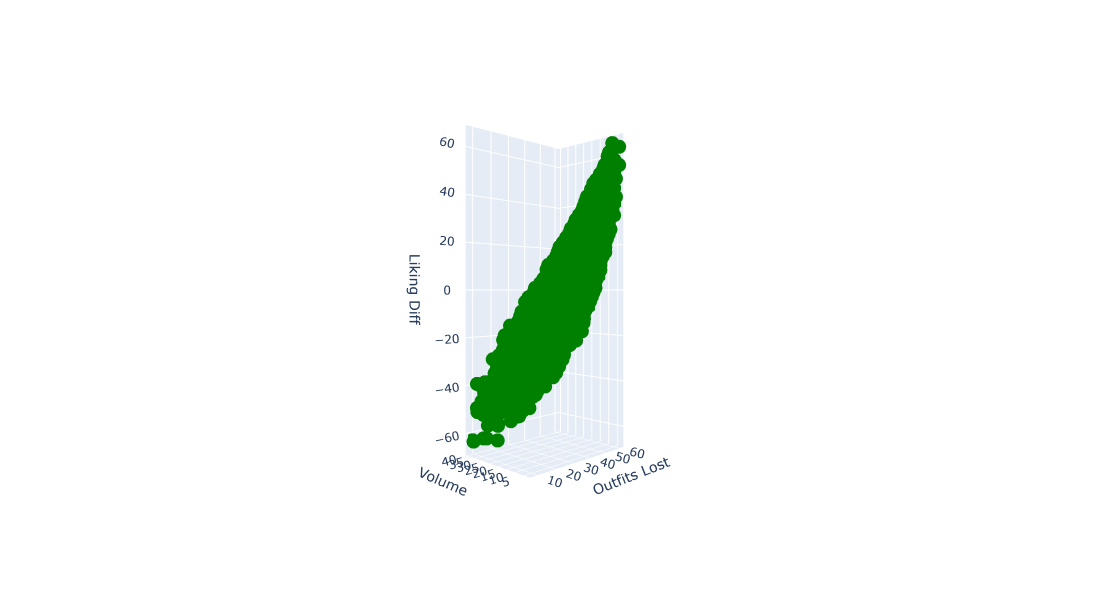

In [6]:
fig = px.scatter_3d(x=vis_subset["outfits_lost"], y=vis_subset["volume"], z=vis_subset["liking_diff"], color_discrete_sequence=["green"])
camera = dict(
    eye=dict(x=-2.5, y=-2.5, z=0)
)
fig.update_layout(scene_camera=camera)
fig.update_layout(scene=dict(xaxis_title="Outfits Lost", yaxis_title = "Volume", zaxis_title = "Liking Diff"))
fig.update_layout(height=600,width=500,autosize=False)
fig.show()

For simplicity/in case the above fails to render for some users, we can also do three 2D plots, in which each plot has two objectives on the x/y-axises and the third objective is represented with color. Note each plot is displaying the same points as the others, and is just snapshotting what you would see if you looked at individual faces of the cube.  
**2D Representaion:**

In [7]:
2**20

1048576

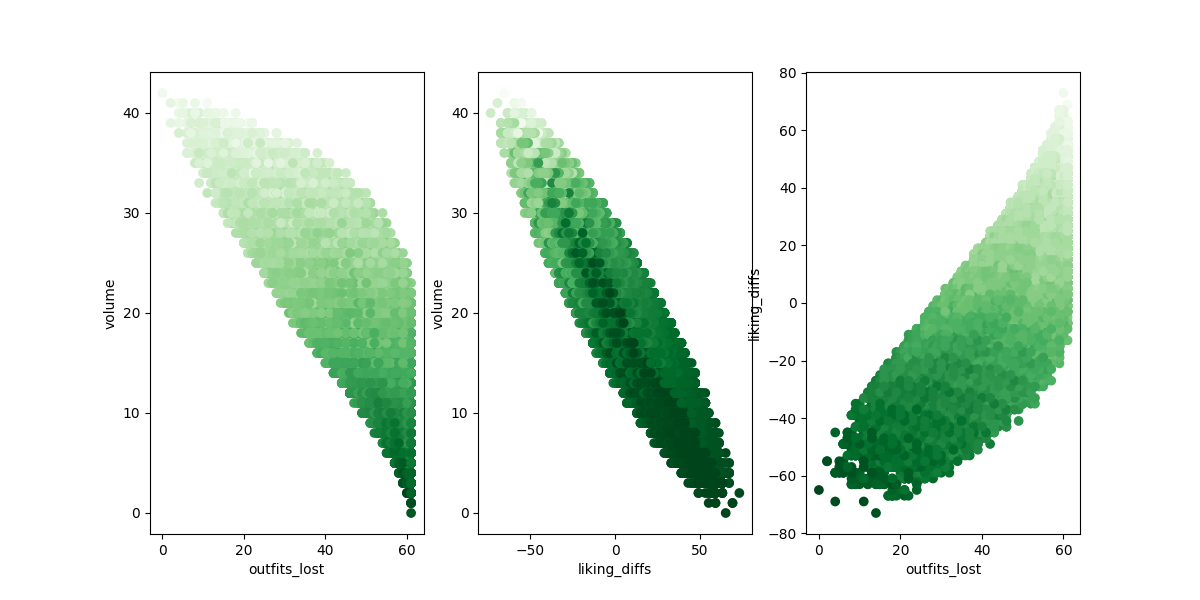

In [8]:
# # plotting 1048576 is lots of memory so I saved the images to display in notebook
# # if you edit and need to regenerate plots, uncomment below

# plt.figure(figsize=(12, 6))

# plt.subplot(1,3,1)
# plt.scatter(data=all_objs, x="outfits_lost", y="volume", c="liking_diff", cmap='Greens')
# #plt.scatter(data=vis_subset, x="outfits_lost", y="volume", c="liking_diff", cmap='Greens')
# plt.xlabel("outfits_lost")
# plt.ylabel("volume")

# plt.subplot(1,3,2)
# plt.scatter(data=all_objs, x="liking_diff", y="volume", c="outfits_lost", cmap='Greens')
# #plt.scatter(data=vis_subset, x="liking_diff", y="volume", c="outfits_lost", cmap='Greens')
# plt.xlabel("liking_diffs")
# plt.ylabel("volume")

# plt.subplot(1,3,3)
# plt.scatter(data=all_objs, x="outfits_lost", y="liking_diff", c="volume", cmap='Greens')
# #plt.scatter(data=vis_subset, x="outfits_lost", y="liking_diff", c="volume", cmap='Greens')
# plt.xlabel("outfits_lost")
# plt.ylabel("liking_diffs")

Image(filename='all_solns_2d.png')

Here, each dot represents one suitcase - as you can see, a suitcase with scores (0, 0, -75) isn't possible. **The crux of this process is getting as close to that ideal as you can, via various methods**

### The Pareto Front

Naturally, one clear solution doesn't necessarily present itself - in any case with multi-objective functions, but especially in a case where features are negatively correlated (e.g. less volume will always = more outfits_lost). \
However, some are decidedly better than others. For example, looking at the first plot, let's say you could only tolerate losing at most 40 outfits. Even within that restriction, there are many different solutions, but there is one solution at which volume is the minimum, in this case somewhere around 15. Each pairwise graph has this kind of "wall" that lines the shape facing the direction of the optimal solution (0, 0). \
This is called the Pareto front: a set of best possible trade-off solutions where you can't improve one objective without worsening another. For a solution to be a part of the Pareto front, it must have:
* Pareto Dominence: Solution A "dominates" Solution B if A is better in at least one objective and not worse in any other 
* Pareto Optimal: A solution is Pareto optimal if no other solution dominates it \
i.e., a point is discarded if there exists a solution that is better than it in every way. The Pareto Front will consist of all Pareto Optimal points. \
\
e.g. if we have: 
* Solution 1: outfits_lost: 50, volume: 25, liking_diffs = 10
* Solution 2: outfits_lost: 60, volume: 15, liking_diffs = 20
* Solution 3: outfits_lost: 60, volume: 25, liking_diffs = 15

Solution 2 seemingly removes some items from Solution 1, improving the volume metric but worsening the other two. Both solutions remain because Solution 2 could be a good solution if low volume is desired/prioritized.  
Solution 3 looks like a case where there's still more outfit loss compared to 1, but the items kept were heaver, and liked less than those of Solution 1. While it doesn't get dominated by Solution 2 since it still has lower disliking (which again, may be desired), there is no circumstance in which we'd want a solution that is heavier, less liked, and has less outfits than another (Solution 1) so Solution 3 is not in the Pareto Front. 


Here's the Pareto Front for our case (in 3D & 2D respectively):

In [9]:
full_pareto_front_df = pd.read_csv("full_pareto_front_df")

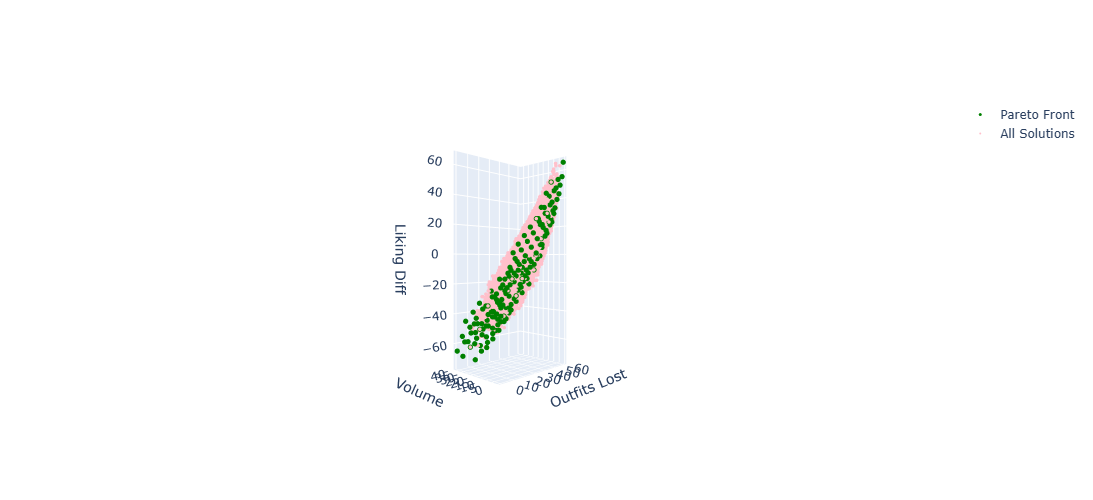

In [10]:
trace1 = go.Scatter3d(x=full_pareto_front_df["outfits_lost"], y=full_pareto_front_df["volume"], z=full_pareto_front_df["liking_diff"], mode='markers', marker=dict(size=3, color="green"), name="Pareto Front")
trace2 = go.Scatter3d(x=vis_subset["outfits_lost"], y=vis_subset["volume"], z=vis_subset["liking_diff"], mode='markers', marker=dict(size=2, color="pink"), name="All Solutions")

camera = dict(
    eye=dict(x=-2.5, y=-2.5, z=0)
)
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(scene_camera=camera)
fig.update_layout(scene=dict(xaxis_title="Outfits Lost", yaxis_title = "Volume", zaxis_title = "Liking Diff"))
fig.update_layout(height=500,width=600,autosize=False)

fig.show()

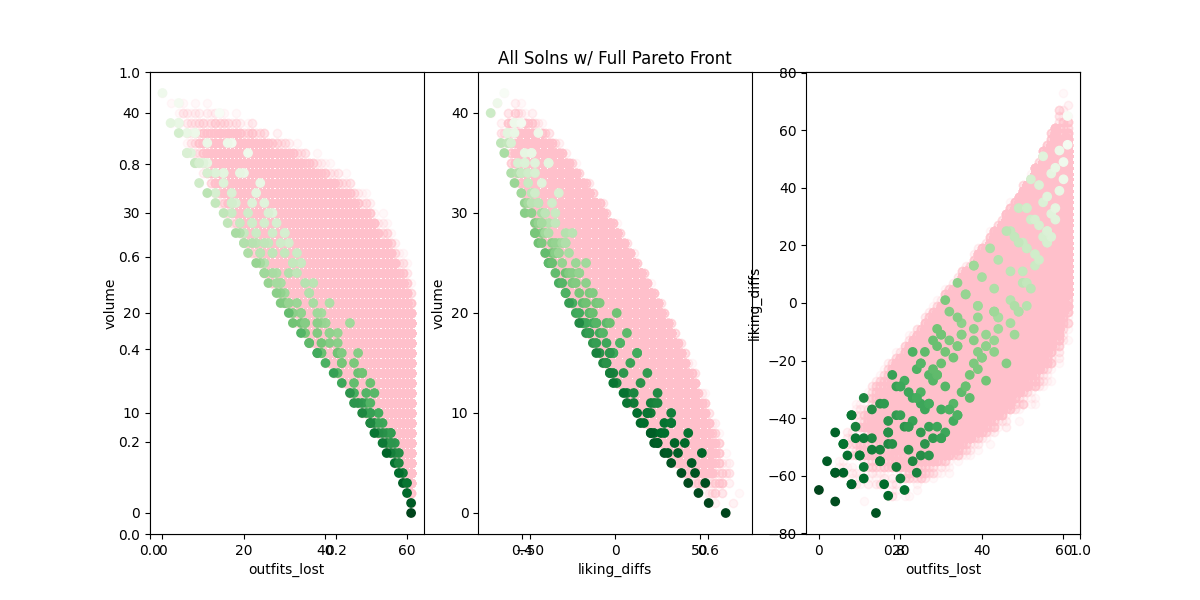

In [11]:
# plt.figure(figsize=(12, 6))
# plt.title("All Solns w/ Full Pareto Front")

# plt.subplot(1,3,1)
# plt.scatter(data=all_objs, x="outfits_lost", y="volume",color='pink', alpha=0.1)
# #plt.scatter(data=vis_subset, x="outfits_lost", y="volume",color='pink', alpha=0.1)
# plt.scatter(data=full_pareto_front_df, x="outfits_lost", y="volume", c="liking_diff", cmap='Greens')
# plt.xlabel("outfits_lost")
# plt.ylabel("volume")

# plt.subplot(1,3,2)
# plt.scatter(data=all_objs, x="liking_diff", y="volume", color='pink', alpha=0.1)
# #plt.scatter(data=vis_subset, x="liking_diff", y="volume", color='pink', alpha=0.1)
# plt.scatter(data=full_pareto_front_df, x="liking_diff", y="volume", c="outfits_lost", cmap='Greens')
# plt.xlabel("liking_diffs")
# plt.ylabel("volume")

# plt.subplot(1,3,3)
# plt.scatter(data=all_objs, x="outfits_lost", y="liking_diff", color='pink', alpha=0.1)
# #plt.scatter(data=vis_subset, x="outfits_lost", y="liking_diff", color='pink', alpha=0.1)
# plt.scatter(data=full_pareto_front_df, x="outfits_lost", y="liking_diff", c="volume", cmap='Greens')
# plt.xlabel("outfits_lost")
# plt.ylabel("liking_diffs")

# plt.savefig('all_solns_with_pf.png')
Image(filename='all_solns_with_pf.png') 

As you can see, the Pareto front is a line or a plane (depending on dimensions/# of objectives) facing the "best" solution, in this case (0, 0, -75). Even though (0, 0, -75) isn't actually possible, since we've set all our objectives to be minimized, the lowest possible value for each is the "goal".

This is the FULL, real Pareto front for this problem. Narrowing these points down further isn't necessarily straightforward as all points on the Pareto front are technically "valid" solutions, necessitating some decision making to take place.

But first you need the Pareto front in the first place, and retrieving these takes almost two hours to run. In a real world scenario you might want to speed this up, or you might be dealing with even more objectives and/or potential solutions.   
This is where taking an algorithmic approach to iteratively locate the Pareto front comes into play in Part 2.